# 多类分类(多个logistic回归)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio  # 加载matlab格式的数据集

F:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
F:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
F:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
F:\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## 获取DataSet

In [8]:
# 加载数据，由于是mat文件格式（matlab），需要用到scipy的loadmat
def load_data(path):
    data = sio.loadmat(path)
    X = data['X']
    y = data['y']
    return X,y

In [29]:
path = './ex3/ex3data1.mat'
X, y = load_data(path)
print(np.unique(y))
X.shape, y.shape

[ 1  2  3  4  5  6  7  8  9 10]


((5000, 400), (5000, 1))

In [12]:
# 可以看到总共有5000个样本，每个样本是20*20像素的数字灰度图像，像素都是个浮点数，代表该位置的灰度
# 20*20像素扩展成400维的向量，每一行代表一个样本，就变成了5000*400的矩阵， 每一行都是手写数字图像的训练样本

第一个任务是将我们的逻辑回归实现修改为完全向量化（即没有“for”循环）。这是因为向量化代码除了简洁外，还能够利用线性代数优化，并且通常比迭代
代码快得多。

## Visualizing the data

In [19]:
# matshow():把矩阵或数组绘制成图像的函数

def plot_image():
    random_one = np.random.randint(0, 5000)
    image = X[random_one, :]
    
    fig = plt.figure(figsize=(1,1))
    ax = plt.axes()
    
    ax.matshow(image.reshape((20,20)), cmap='gray_r')
    plt.yticks([]) # 去除刻度，美观
    plt.xticks([])
    plt.show()

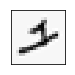

In [20]:
plot_image()

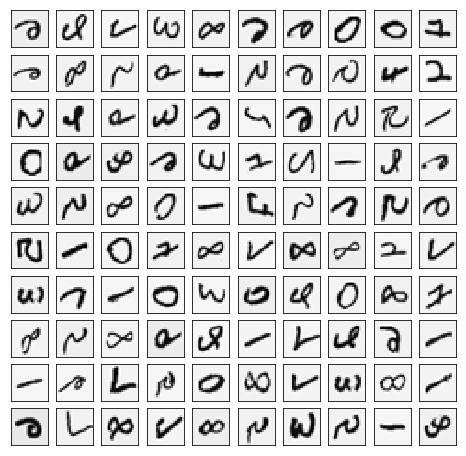

In [24]:
def plot_100_images():
    samples = np.random.choice(np.arange(X.shape[0]), 100)
    images = X[samples,:]
    
    fig, ax = plt.subplots(nrows=10, ncols=10, sharex=True, sharey=True,figsize=(8,8))
    
    for row in range(10):
        for col in range(10):
            ax[row, col].matshow(images[10 * row + col].reshape((20,20)), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()
plot_100_images()

## Vectorizing Logistic Regression

我们将使用多个one-vs-all(一对多)logistic回归模型来构建一个多类分类器。由于有10个类，需要训练10个独立的分类器。为了提高训练效率，
重要的是向量化。在本节中，我们将实现一个不使用任何for循环的向量化的logistic回归版本。

正则化的逻辑回归代价函数  
$$ J(\theta) =  \frac{1}{m} \sum_{i=1}^m[- y^{(i)}\log(h_\theta(x^{(i)})) - (1 - y^{(i)})\log(1 - h_\theta(x^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^n \theta_j^2 $$ 

In [25]:
#可以对所有的样本用矩阵乘法来快速的计算

In [26]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [62]:
def regularized_cost(theta, X, y, l):
    
    theta_reg = theta[1:]
    
    cost = (-y) * np.log(sigmoid(X@theta)) - (1 - y) * np.log(1 - sigmoid(X@theta))
    reg = (theta_reg@theta_reg) * l / (2 * len(X))
    
    return np.mean(cost) + reg

In [34]:
# a = np.array([1,2])
# b = np.array([1,2])
# a @ b # 5

# a * b # array([1, 4])

## Vectorizing the gradient

正则化的logistic回归梯度下降  
Repeat until convergence:  
$$ \theta_0 = \theta_0 - \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_0{(i)} $$
$$ \theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)}) - y^{(i)})x_j{(i)} + \frac{\lambda}{m}\theta_j $$
Repeat

In [47]:
# 求梯度
def regularized_gradient(theta, X, y, l):
    theta_reg = theta[1:]
    partial = l / len(X) * X.T@(sigmoid(X@theta) - y)
    # 为了对theta_0不惩罚，加入theta_0,方便计算
    reg = np.concatenate((np.array([0]), (l / len(X)) * theta_reg))
    return partial + reg

## One-vs-all Classification

这部分我们将实现一对多分类通过训练多个正则化logistic回归分类器，每个对应数据集中K类中的一个。    
对于这个任务，我们有10个可能的类，并且由于logistic回归只能一次在2个类之间进行分类，每个分类器在“类别 i”和“不是 i”之间决定。   
我们将把分类器训练包含在一个函数中，该函数计算10个分类器中的每个分类器的最终权重，并将权重返回shape为(k, (n+1))数组，其中 n 是参数数量。  

In [80]:
from scipy.optimize import minimize

def one_vs_all(X, y, l, K):
    
    all_theta = np.zeros((K, X.shape[1]))  # K类 每行401个参数值
    
    for i in range(1, K+1):
        theta = np.zeros(X.shape[1])
        y_i = np.array([1 if label == i else 0 for label in y])
        ret = minimize(fun = regularized_cost, x0 = theta, args = (X, y_i, l), method = 'TNC',
                        jac = regularized_gradient, options={'disp': True})
        #print(ret.x) # 获得最小化代价函数的参数
        all_theta[i-1,:] = ret.x
    return all_theta

In [65]:
# 这里需要注意的几点：首先，我们为X添加了一列常数项 1 ，以计算截距项（常数项）。 
# 其次，我们将y从类标签转换为每个分类器的二进制值（要么是类i，要么不是类i）。
# 最后，我们使用SciPy的较新优化API来最小化每个分类器的代价函数。 如果指定的话，API将采用目标函数，初始参数集，优化方法和jacobian（渐变）函数。
# 然后将优化程序找到的参数分配给参数数组。

In [66]:
# numpy.argmax(a, axis=None, out=None) 
# 返回沿轴axis最大值的索引

In [67]:
def predict_all(X, all_theta):
    h = sigmoid(X@all_theta.T)
    
    h_argmax = np.argmax(h, axis=1) # 1代表行 0代表列
    h_argmax = h_argmax + 1 # 因为索引是从0开始的，而y 从1开始
    return h_argmax

In [81]:
raw_X, raw_y = load_data('./ex3/ex3data1.mat')
X = np.insert(raw_X, 0, 1, axis=1)  # 插入偏置项 (5000, 401)
y = raw_y.flatten() # flatten 降维到一维

all_theta = one_vs_all(X, y, 1, 10)
all_theta # 每一行就是一组分类器的参数

array([[-2.38120632e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.30520871e-03, -9.34051816e-10,  0.00000000e+00],
       [-3.18336957e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.46340223e-03, -5.08880580e-04,  0.00000000e+00],
       [-4.79894740e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.86619702e-05, -2.47209891e-07,  0.00000000e+00],
       ...,
       [-7.98738710e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.94653400e-05,  7.21239651e-06,  0.00000000e+00],
       [-4.57199032e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.33791002e-03,  9.99342936e-05,  0.00000000e+00],
       [-5.40412466e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.16606730e-04,  7.87540219e-06,  0.00000000e+00]])

In [82]:
y_pred = predict_all(X, all_theta)
accuracy = np.mean(y_pred==y)
accuracy

0.9446

# Neural Networks

In [83]:
#上面使用了多类logistic回归，然而logistic回归不能形成更复杂的假设，因为它只是一个线性分类器。

#接下来我们用神经网络来尝试下，神经网络可以实现非常复杂的非线性的模型。我们将利用已经训练好了的权重进行预测。

In [84]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']

In [85]:
theta1, theta2 = load_weight('./ex3/ex3weights.mat')
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [86]:
# 因此在数据加载函数中，原始数据做了转置，然而，转置的数据与给定的参数不兼容，因为这些参数是由原始数据训练的。 所以为了应用给定的参数，
# 我需要使用原始数据（不转置）

In [89]:
X, y = load_data('./ex3/ex3data1.mat')
y = y.flatten()
X = np.insert(X, 0, 1, axis=1)  # intercept

X.shape, y.shape

((5000, 401), (5000,))

In [90]:
a1 = X
z2 = a1 @ theta1.T
z2.shape

(5000, 25)

In [91]:
z2 = np.insert(z2, 0, 1, axis=1)

In [93]:
a2 = sigmoid(z2)
a2.shape

(5000, 26)

In [94]:
z3 = a2 @ theta2.T
z3.shape

(5000, 10)

In [95]:
a3 = sigmoid(z3)
a3.shape

(5000, 10)

In [96]:
y_pred = np.argmax(a3, axis=1) + 1 
accuracy = np.mean(y_pred == y)
accuracy

0.9752

In [ ]:
# 虽然人工神经网络是非常强大的模型，但训练数据的准确性并不能完美预测实际数据，在这里很容易过拟合。